## Mask R-CNN - Simulate the `DetectionTargetLayer` Process for COCO images

We generate the inputs to `DetectTargetLayer` , to manipulate and modify the layer to procduce a modified `output_rois` 
containing false positives. 
This will be passed on the the heatmap layer, and through there will become the input to FCN.

### Build Model

In [ ]:
# np_format = {}
# float_formatter = lambda x: "%10.4f" % x
# int_formatter   = lambda x: "%10d" % x
# np_format['float'] = float_formatter
# np_format['int']   = int_formatter
# np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)

In [43]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint, pickle
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')

import mrcnn.utils        as utils
import mrcnn.visualize    as visualize
import mrcnn.prep_notebook as prep
from datetime            import datetime   
from mrcnn.utils         import command_line_parser, Paths
from mrcnn.datagen       import data_generator, load_image_gt, data_gen_simulate
from mrcnn.prep_notebook import mrcnn_newshape_train
from mrcnn.newshapes     import prep_newshape_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = " --epochs           2 "
input_parms +=" --steps_in_epoch  10 "
input_parms +=" --last_epoch       0" 
input_parms +=" --batch_size       1 " 
input_parms +=" --lr          0.0001 "
input_parms +=" --val_steps        8 " 
input_parms +=" --mrcnn_logs_dir  train_mrcnn_newshapes "
input_parms +=" --fcn_logs_dir    train_fcn8_l2_newshapes "
input_parms +=" --mrcnn_model     last "
input_parms +=" --fcn_model       init "
input_parms +=" --fcn_layers      all " 
input_parms +=" --fcn_arch        fcn8L2 " 
input_parms +=" --opt             adam "
input_parms +=" --scale_factor     1 " 
input_parms +=" --sysout          screen "
input_parms +=" --new_log_folder    "

args = parser.parse_args(input_parms.split())
# print(args)
utils.display_input_parms(args)
print(type(args.mrcnn_layers))


   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   epochs                         2
   evaluate_method                1
   fcn_arch                       FCN8L2
   fcn_layers                     ['all']
   fcn_logs_dir                   train_fcn8_l2_newshapes
   fcn_losses                     fcn_BCE_loss
   fcn_model                      init
   last_epoch                     0
   lr                             0.0001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
   mrcnn_logs_dir                 train_mrcnn_newshapes
   mrcnn_model                    last
   new_log_folder                 True
   opt                            ADAM
   scale_factor                   1
   steps_in_epoch                 10
   sysout                         SCREEN
   val_steps                      8


<class 'list'>


In [45]:
from mrcnn.prep_notebook import build_fcn_training_pipeline_newshapes
mrcnn_model, fcn_model = build_fcn_training_pipeline_newshapes(args = args, verbose = 1)
# mrcnn_model= mrcnn_newshape_train(args = args)


   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   epochs                         2
   evaluate_method                1
   fcn_arch                       FCN8L2
   fcn_layers                     ['all']
   fcn_logs_dir                   train_fcn8_l2_newshapes
   fcn_losses                     fcn_BCE_loss
   fcn_model                      init
   last_epoch                     0
   lr                             0.0001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
   mrcnn_logs_dir                 train_mrcnn_newshapes
   mrcnn_model                    last
   new_log_folder                 True
   opt                            ADAM
   scale_factor                   1
   steps_in_epoch                 10
   sysout                         SCREEN
   val_steps                      8


>>> Initialize Paths
 windows  Windows
>>> Initialize ModelBase model 
   Mode  

   FCN Block 44 (Max pooling) shape is :  (?, 8, 8, 512)
   FCN Block 51 shape is               :  (None, 8, 8, 512)
   FCN Block 52 shape is               :  (None, 8, 8, 512)
   FCN Block 53 shape is               :  (None, 8, 8, 512)
   FCN Block 54 (Max pooling) shape is :  (None, 4, 4, 512)

   --- FCN32 ----------------------------
   FCN fully connected 1 (fc1) shape   :  (None, 4, 4, 4096)
***** Call to Dropout Layer : Training is :  None
***** in_train_phase() : Use_learning_phase:  True
   FCN fully connected 2 (fc2) shape   :  (None, 4, 4, 4096)
***** Call to Dropout Layer : Training is :  None
***** in_train_phase() : Use_learning_phase:  True
   FCN conv2d (fcn32_deconv2D) shape   :  (?, 4, 4, 7)  keras_tensor  True

   --- FCN16 ----------------------------
   FCN scorePool4 (Conv2D(Pool4)) shape is                   :  (None, 8, 8, 7)    keras_tensor  True
   FCN 2x Upsampling (Deconvolution2D(fcn32_classify)) shape :  (None, 10, 10, 7)    keras_tensor  True
   FCN 2x Up

    alt_scores_2                   :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_2(scattered)        :  shape: (1, 7, 32, 3)         KB.shape:(1, 7, 32, 3)         Keras Tensor: False
    alt_scores_2_norm(by_class)    :  shape: (1, 7, 32, 3)         KB.shape:(1, 7, 32, 3)         Keras Tensor: False
    alt_scores_2_norm(by_image)    :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    fcn_scores_dense               :  shape: (?, 23)               KB.shape:(None, 23)            Keras Tensor: False
    seq_ids                        :  shape: (?,)                  KB.shape:(None,)               Keras Tensor: False
    sscatter_ids                   :  shape: (?, 2)                KB.shape:(None, 2)             Keras Tensor: False
    fcn_scores_by_class            :  shape: (1, 7, 32, 23)        KB.shape:(1, 7, 32, 23)        Keras Tensor: False
    complete                       
 GT HM.op_type()    

17      Tensor("fcn16_upscore_pool4/weight_regularizer/add:0", shape=(), dtype=float32)
18      Tensor("block2_conv1/weight_regularizer/add:0", shape=(), dtype=float32)
19      Tensor("fcn8_score_pool3/weight_regularizer/add:0", shape=(), dtype=float32)
20      Tensor("block3_conv3/weight_regularizer/add:0", shape=(), dtype=float32)

>>> FCN build complete. mode:  training
>>> FCN initialization complete. mode:  training

 FCN Configuration Parameters 
 ------------------------------ 

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_PERIOD              1
DETECTION_MAX_INSTANCES        64
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            64
DIR_DATASET                    F:\MLDatase

###  Load Model Weights

In [3]:
# exclude=["mrcnn_class_logits" ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
# exclude = None
# mrcnn_model.load_model_weights(init_with = 'coco', exclude = exclude)  

### Dataset

In [9]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
# del dataset_train, dataset_val, train_generator, val_generator
# from mrcnn.prep_notebook import prep_newshape_dataset
# dataset_train, train_generator = prep_newshape_dataset( mrcnn_model.config, 5000, generator=True)
# dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_model.config,  1250, generator=True)

## -- OR --
import pickle

with open('E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_training_dataset_10000_A.pkl', 'rb') as outfile:
    dataset_train = pickle.load(outfile)
with open('E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_validation_dataset_2500_A.pkl', 'rb') as outfile:
    dataset_val = pickle.load(outfile)
## If we desire a generator, here it is:    
train_generator = data_generator(dataset_train, mrcnn_model.config, batch_size=mrcnn_model.config.BATCH_SIZE,
                                   shuffle = True, augment = False) 
val_generator = data_generator(dataset_val, mrcnn_model.config, batch_size=mrcnn_model.config.BATCH_SIZE,
                                   shuffle = True, augment = False) 
class_names = dataset_train.class_names
print(mrcnn_model.config.BATCH_SIZE, fcn_model.config.BATCH_SIZE)
print(len(dataset_train.image_ids), len(dataset_val.image_ids))

1 1
10000 2500


### Display random samples from dataset

####  Display some images from training and val datasets

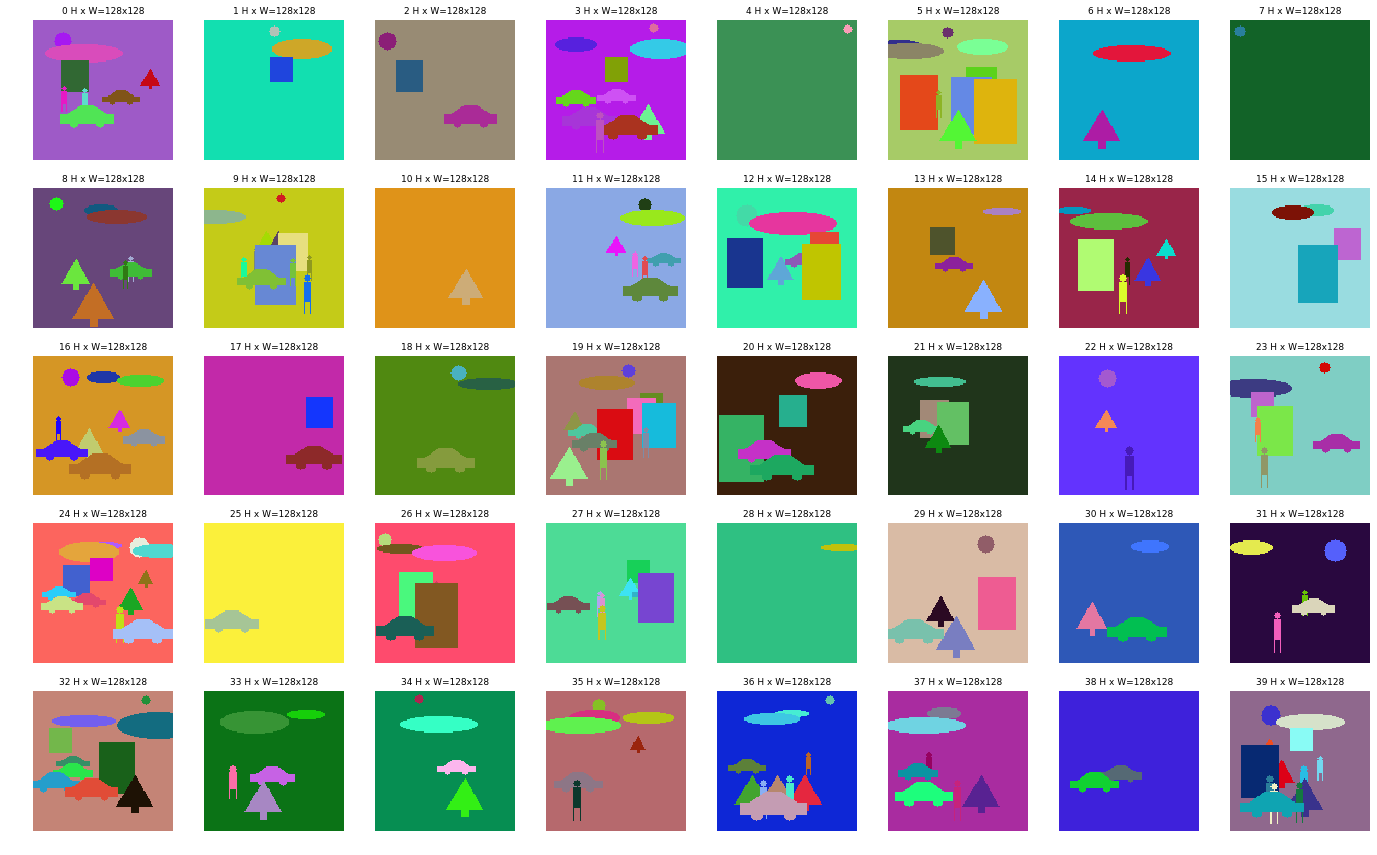

In [12]:
image_list = list(range(0,40))
image_titles = [str(i) for i in image_list]
images = prep.get_image_batch(dataset_train, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

#### Display top masks for a random group of images

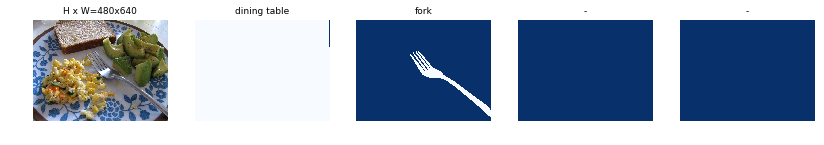

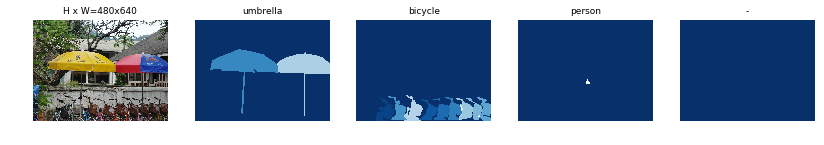

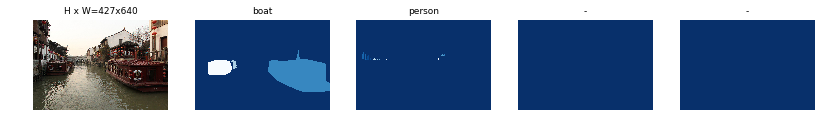

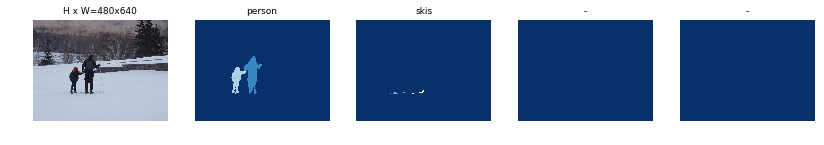

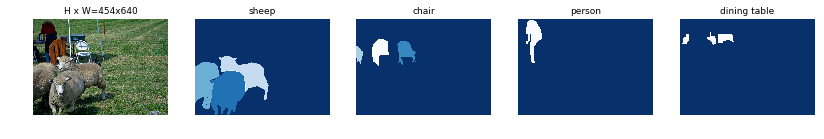

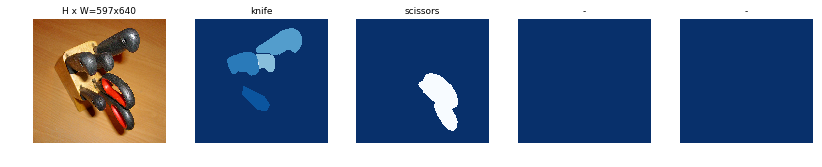

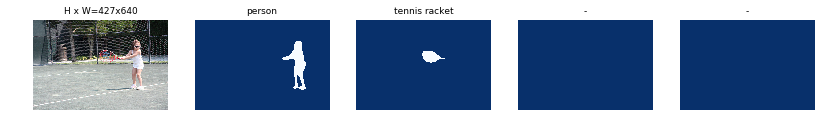

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Display one image and it's instances

image_id  27711 http://cocodataset.org/#explore?id=324412
image                    shape: (346, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (346, 640, 7)         min:    0.00000  max:    1.00000
class_ids                shape: (7,)                  min:    1.00000  max:    9.00000
bbox                     shape: (7, 4)                min:  108.00000  max:  503.00000
7 7


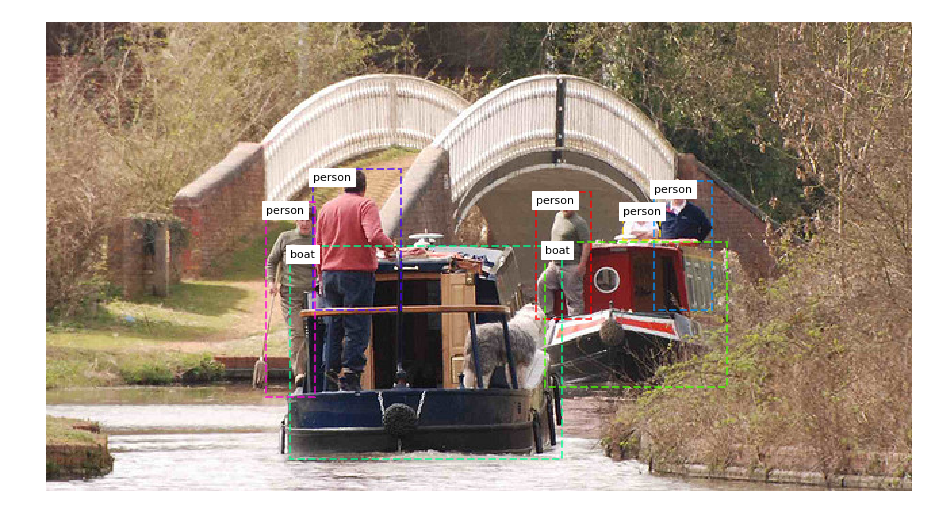

In [9]:
# Load random image and mask. ### 27711 persons and boats
image_id = np.random.choice(dataset_train.image_ids)
image    = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)
visualize.display_instances(image, bbox, class_ids, dataset_train.class_names)

### Get image from generator and display object instances

image id :  10
 Image_id    :  10  Reference:  [('tree', (205, 172, 119), (83, 87, 19, 19))] Coco Id: 10
 Image meta  :  [ 10 128 128   3   0   0 128 128]
 Class ids   :  (1,)    [5]
 Class Names :  ['tree']


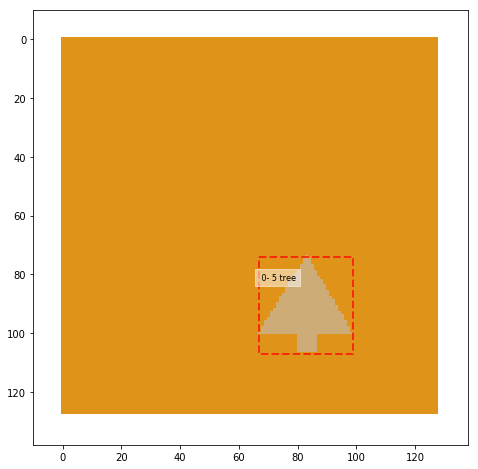

[ 10 128 128   3   0   0 128 128   1   1   1   1   1   1   1]


In [13]:
IMAGE_IDS = [10]
# train_batch_x, train_batch_y = next(train_generator)
train_batch_x, train_batch_y = data_gen_simulate(dataset_train, mrcnn_model.config, IMAGE_IDS)
visualize.display_training_batch(dataset_train, train_batch_x)
print(train_batch_x[1][0])

In [ ]:
# train_batch_x, train_batch_y = next(train_generator)

In [30]:
results = mrcnn_model.keras_model.predict(train_batch_x)

print(type(results))
for i in results:
    print( i.shape)


Loading 1 images
image                    shape: (128, 128, 3)         min:   25.00000  max:  223.00000


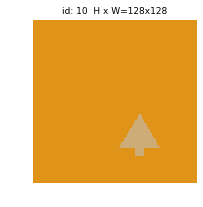

image id :  10
 Image_id    :  10  Reference:  [('tree', (205, 172, 119), (83, 87, 19, 19))] Coco Id: 10
 Image meta  :  [ 10 128 128   3   0   0 128 128]
 Class ids   :  (1,)    [5]
 Class Names :  ['tree']


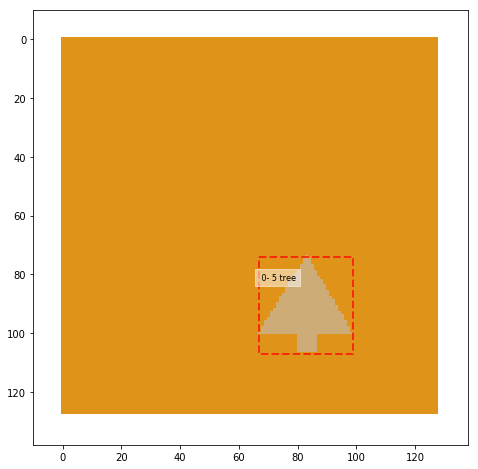

** Pass through MRCNN model:
/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 15)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

Requested layers:
-----------------
Layer   0:  (cntxt_layer/pred_heatmap:0              ) 	  Output shape: (1, 128, 128, 7)
Layer   1:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (1, 7, 32, 23)
Layer   2:  (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (1, 128, 128, 7)
Layer   3:  (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (1, 7, 32, 23)
Layer   4:  (mrcnn_class_lambda/mrcnn_class:0        ) 	  Output shape: (?, 32

In [35]:
results =  prep.run_mrcnn_training_pipeline(mrcnn_model, dataset_train, mrcnn_input = None, image_ids = 10, verbose = 1)

print(type(results))
for i in results:
#     print( i.shape)
    print(i)
    for j in results[i]:
        print('      ',j.shape)

###  Display image with Ground Truth bounding boxes and masks

In [7]:
# ### Display loaded shapes
# from mrcnn.datagen import data_gen_simulate
# # IMAGE_IDS = [36466]
# # IMAGE_IDS = [27711]
# # IMAGE_IDS = [29731]
# train_batch_x, train_batch_y = next(train_generator)
# # train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_config, IMAGE_IDS )
# # train_batch_x, train_batch_y = mrcnn.datagen_mod train_generator)

# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
# img_meta    = train_batch_x[imgmeta_idx]
# class_names = dataset_train.class_names

# for img_idx in range(mrcnn_config.BATCH_SIZE):
#     image_id = img_meta[img_idx,0]
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     bbox = utils.extract_bboxes(mask)
#     print('Image meta  : ', img_meta[img_idx,:10])
#     print('Classes     : ', class_ids)
#     print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
#     print(' class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0])    
    
#     class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
#     print('Class Names : ', class_names)
    
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
#     # Display image and instances
#     visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8)) 

In [32]:
len(train_batch_x)

6

###  Print some model information 

In [6]:
mrcnn_model.layer_info()



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 index:  2    input name : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 index:  3    input name : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 index:  4    input name : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 index:  5    input name : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)


 Outputs:
 --------
 layer:  0    output name: rpn_class_logits/rpn_class_logits:0        Type: float32           Shape: (?, ?, 2)
 layer:  1    output name: rpn_class/rpn_class:0                      Type: float32           Shape: (?, ?, 2)
 layer:  2    output name: rpn_bbox/rpn_bbox:0                     

## Pass data through the model 

### Get image from generator and display object instances

image id :  10
 Image_id    :  10  Reference:  [('tree', (205, 172, 119), (83, 87, 19, 19))] Coco Id: 10
 Image meta  :  [ 10 128 128   3   0   0 128 128]
 Class ids   :  (1,)    [5]
 Class Names :  ['tree']


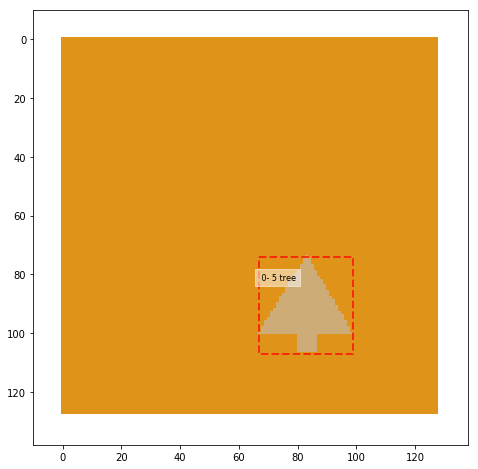

[ 10 128 128   3   0   0 128 128   1   1   1   1   1   1   1]


In [46]:
IMAGE_IDS = [10]
# train_batch_x, train_batch_y = next(train_generator)
train_batch_x, train_batch_y = data_gen_simulate(dataset_train, mrcnn_model.config, IMAGE_IDS)
visualize.display_training_batch(dataset_train, train_batch_x)
print(train_batch_x[1][0])

#### Push Data thru model using get_layer_output()

In [47]:
# model_output 
model_output = mrcnn_model.get_layer_outputs(train_batch_x,  verbose = True, training_flag = True)

for i in model_output:
#     print( i.shape)

    print(i.shape, type(i), np.any(np.isnan(i)))   

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 15)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

Requested layers:
-----------------
Layer   0:  (cntxt_layer/pred_heatmap:0              ) 	  Output shape: (1, 128, 128, 7)
Layer   1:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (1, 7, 32, 23)
Layer   2:  (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (1, 128, 128, 7)
Layer   3:  (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (1, 7, 32, 23)
Layer   4:  (mrcnn_class_lambda/mrcnn_class:0        ) 	  Output shape: (?, 32, 7)
Layer   5:  (mrcnn_bbox_

#### Push Data thru model using model.predict()

In [40]:
results = mrcnn_model.keras_model.predict(train_batch_x)
print(type(results))
for i in results:
    print(i.shape)
for i in results:
#     print( i.shape)
    print(i.shape, type(i), np.any(np.isnan(i)))

<class 'list'>
(1, 128, 128, 7)
(1, 7, 32, 23)
(1, 128, 128, 7)
(1, 7, 32, 23)
(1, 32, 7)
(1, 32, 7, 4)
(1, 32, 4)
(1, 32)
(1, 32, 4)
(1, 32, 7)
(1, 7)
(1, 2000, 4)
(1, 128, 128, 7) <class 'numpy.ndarray'> False
(1, 7, 32, 23) <class 'numpy.ndarray'> False
(1, 128, 128, 7) <class 'numpy.ndarray'> False
(1, 7, 32, 23) <class 'numpy.ndarray'> False
(1, 32, 7) <class 'numpy.ndarray'> False
(1, 32, 7, 4) <class 'numpy.ndarray'> False
(1, 32, 4) <class 'numpy.ndarray'> False
(1, 32) <class 'numpy.ndarray'> False
(1, 32, 4) <class 'numpy.ndarray'> False
(1, 32, 7) <class 'numpy.ndarray'> False
(1, 7) <class 'numpy.ndarray'> False
(1, 2000, 4) <class 'numpy.ndarray'> False


####  Load input data

In [48]:
# del input_image, input_image_meta, input_gt_class_ids, input_gt_bboxes #, input_gt_bboxes_norm
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)

h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
print(h,w)
input_gt_bboxes_norm = input_gt_bboxes / [h,w,h,w]
# print(' input_gt_bboxes_norm     :', input_gt_bboxes_norm.shape)

#### Load output data

print(len(model_output))
# model_rpn_class_logits          = model_output[0]          # layer:  0   shape: (1, 261888, 2)
# model_rpn_class                 = model_output[1]          # layer:  1   shape: (1, 261888, 2)
# model_rpn_bbox                  = model_output[2]          # layer:  2   shape: (1, 261888, 4)
# model_rpn_roi_proposals         = model_output[3]          # layer:  3   shape: (1, 1000, 4)

model_pred_heatmap              = model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
model_pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (1, 81, 200, 23)
model_gt_heatmap                = model_output[2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (1, 81, 200, 23)
model_mrcnn_class               = model_output[4]          # layer:  4   shape: (1, 200, 81)
model_mrcnn_bbox                = model_output[5]          # layer:  5   shape: (1, 200, 81, 4)
model_output_rois               = model_output[6]          # layer:  6   shape: (1, 200, 4)
model_target_class_ids          = model_output[7]          # layer:  7   shape: (1, 32)
model_target_bbox_deltas        = model_output[8]          # layer:  8   shape: (1, 32, 4)
model_roi_gt_boxes              = model_output[9]          # layer:  9   shape: (1, 32, 4)
model_mrcnn_class_logits        = model_output[10]          # layer: 10   shape: (1, 32, 7)
model_active_class_ids          = model_output[11]          # layer: 11   shape: (1, 7)
model_rpn_roi_proposals         = model_output[12]          # layer: 12   shape: (1, 2000, 4)
for i in model_output:
    print(i.shape, type(i), np.any(np.isnan(i)))    

 Input image shape is    : (1, 128, 128, 3)
 Input image_meta        : (1, 15)
 input_image_meta        : [ 10 128 128   3   0   0 128 128   1   1]
 input_gt_class_ids      : (1, 100)
 input_gt_bboxes         : (1, 100, 4)
128 128
13
(1, 128, 128, 7) <class 'numpy.ndarray'> False
(1, 7, 32, 23) <class 'numpy.ndarray'> False
(1, 128, 128, 7) <class 'numpy.ndarray'> False
(1, 7, 32, 23) <class 'numpy.ndarray'> False
(1, 32, 7) <class 'numpy.ndarray'> False
(1, 32, 7, 4) <class 'numpy.ndarray'> False
(1, 32, 4) <class 'numpy.ndarray'> False
(1, 32) <class 'numpy.ndarray'> False
(1, 32, 4) <class 'numpy.ndarray'> False
(1, 32, 4) <class 'numpy.ndarray'> False
(1, 32, 7) <class 'numpy.ndarray'> False
(1, 7) <class 'numpy.ndarray'> False
(1, 2000, 4) <class 'numpy.ndarray'> False


## Display output from Model

In [68]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

### Display raw outputs

####  Display `input_rpn_bboxes`

In [84]:
 
print(input_rpn_bbox.shape)
print(input_rpn_bbox[0,:10])


(1, 256, 4)
[[ 0.293   0.6641  0.5013 -0.6232]
 [ 0.293  -0.5859  0.5013 -0.6232]
 [-0.957   0.6641  0.5013 -0.6232]
 [-0.957  -0.5859  0.5013 -0.6232]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]


####  Display `rpn_class`

In [90]:
print(model_rpn_class.shape)
# print(model_rpn_class[0,:200] )
print(np.where(model_rpn_class[0,:,0] == 1.)[0].shape)
print(np.where(model_rpn_class[0,:,0] != 1.)[0].shape)

(1, 261888, 2)
(135059,)
(126829,)


####  Display `input_gt_class_ids`, `input_gt_bboxes_norm`, `input_gt_bboxes`

In [19]:

print(input_gt_class_ids.shape)
print(input_gt_class_ids[0])
print(input_gt_bboxes_norm.shape)
print(input_gt_bboxes_norm[0,:10])
print(input_gt_bboxes.shape)
print(input_gt_bboxes[0,:10])

(1, 100)
[48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
(1, 100, 4)
[[0.3691 0.3125 0.6455 0.5332]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]
(1, 100, 4)
[[378 320 661 546]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]


####  Display `rpn_roi_proposals`

In [80]:
print(model_rpn_roi_proposals.shape)
# print(model_rpn_roi_proposals[0,:200] )
Y1 = model_rpn_roi_proposals[0,:,2] - model_rpn_roi_proposals[0,:,0]
X1 = model_rpn_roi_proposals[0,:,3] - model_rpn_roi_proposals[0,:,1]
print(Y1[:300])

(1, 2000, 4)
[0.0315 0.0589 0.0599 0.0334 0.031  0.0274 0.029  0.028  0.0359 0.0294 0.0318 0.0348 0.028  0.0274
 0.0604 0.0292 0.0324 0.0738 0.0234 0.0261 0.0513 0.0336 0.0315 0.0262 0.0366 0.0217 0.0403 0.0216
 0.0347 0.0279 0.0241 0.0282 0.049  0.0257 0.0266 0.0262 0.0348 0.0616 0.0321 0.0318 0.0276 0.0332
 0.0338 0.0268 0.0298 0.0312 0.0282 0.0348 0.0524 0.0325 0.0812 0.0204 0.0262 0.0365 0.0353 0.0299
 0.0285 0.0374 0.0247 0.0466 0.0341 0.0516 0.0268 0.0288 0.0432 0.0293 0.0391 0.0381 0.0276 0.0256
 0.0352 0.0229 0.0309 0.0251 0.0255 0.02   0.0407 0.0294 0.0279 0.0352 0.0429 0.0237 0.0257 0.0207
 0.0348 0.0375 0.0278 0.0278 0.0619 0.0241 0.0276 0.0283 0.0793 0.012  0.029  0.0524 0.0303 0.0374
 0.0327 0.0452 0.0384 0.0277 0.0387 0.0251 0.0286 0.0341 0.0353 0.0113 0.0241 0.0229 0.0241 0.037
 0.0827 0.0354 0.0347 0.0429 0.0763 0.0353 0.0194 0.0254 0.025  0.0302 0.0256 0.0312 0.0264 0.0538
 0.0358 0.0336 0.0359 0.0438 0.0351 0.0225 0.024  0.0213 0.0295 0.0152 0.0273 0.0194 0.0214 0.033

####  Display `target_bbox_delta`

In [49]:
print(model_target_bbox_deltas[0])

[[ 1.9796 -0.4221 -0.6444 -2.0395]
 [-0.5558 -0.2723 -2.147  -3.6478]
 [ 0.5291  0.1875 -2.1473 -2.2516]
 [ 2.68   -2.3634 -2.4937 -3.2349]
 [ 1.5979  3.4126 -2.4216 -2.1384]
 [-0.0165 -0.73   -0.9799 -2.0362]
 [ 1.4951 -3.6227 -2.3479 -1.8849]
 [ 0.6246  1.2593 -2.7949 -5.0217]
 [ 1.7107  1.404  -1.9118 -2.1855]
 [-1.8942 -2.7578 -2.4987 -2.9741]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0

####  Compute refinement between `output_roi` and `roi_gt_bboxes` (individually and using numpy arrays)

In [157]:
img_idx = 0
print(model_target_class_ids.shape)
pos_roi_count =  np.count_nonzero(model_target_class_ids[img_idx])
print('positive roi count :', pos_roi_count, '    (delta refinement is only calculated on the positive rois) \n')
for i in range(pos_roi_count):
    t1 = utils.box_refinement(model_output_rois[0,i], model_roi_gt_boxes[0,i])
    t1 = t1 / mrcnn_model.config.BBOX_STD_DEV
    
    print(' row {:2d}            output roi:  {} '.format(i, model_output_rois[0,i])) 
    print('         corresponding gt_box:  {} '.format(model_roi_gt_boxes[0,i]))
    print('   t1 (calculated refinement):  {} '.format(t1))          
    print('      model_target_bbox_delta:  {} '.format(model_target_bbox_deltas[0,i]))
    print()

(1, 32)
positive roi count : 10     (delta refinement is only calculated on the positive rois) 

 row  0            output roi:  [    0.5023     0.4764     0.7956     0.8523] 
         corresponding gt_box:  [    0.5781     0.5234     0.8359     0.7734] 
   t1 (calculated refinement):  [    1.9796    -0.4221    -0.6444    -2.0395] 
      model_target_bbox_delta:  [    1.9796    -0.4221    -0.6444    -2.0395] 

 row  1            output roi:  [    0.5310     0.4033     0.9271     0.9218] 
         corresponding gt_box:  [    0.5781     0.5234     0.8359     0.7734] 
   t1 (calculated refinement):  [   -0.5558    -0.2723    -2.1470    -3.6478] 
      model_target_bbox_delta:  [   -0.5558    -0.2723    -2.1470    -3.6478] 

 row  2            output roi:  [    0.4880     0.4450     0.8841     0.8372] 
         corresponding gt_box:  [    0.5781     0.5234     0.8359     0.7734] 
   t1 (calculated refinement):  [    0.5291     0.1875    -2.1473    -2.2516] 
      model_target_bbox_delta:  

####  display output_rois, 
- apply bbox_deltas to output_rois

In [161]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois', model_output_rois.shape)
scaler = [128,128,128,128]
print(model_output_rois [0,60:70]* scaler)

##---------------------------------------------------------------------------
## applying bbox deltas to output_rois results in the corresponding gt_bbox
## for POSITIVE proposals in the output_roi. For negative samples, it returns 
## in the negative_bbox coordinates itself. 
##---------------------------------------------------------------------------
print('------------------------------------')
print(' Applying bbox deltas to output_rois')
print('------------------------------------')
print(' BBOX STD DEV: ', mrcnn_model.config.BBOX_STD_DEV)
t1 = model_target_bbox_deltas * mrcnn_model.config.BBOX_STD_DEV

print('\n target_bbox_deltas : ', model_target_bbox_deltas[0].shape)
print(model_target_bbox_deltas[0,:70])

print('\n target_bbox_deltas * STD_DEV ', mrcnn_model.config.BBOX_STD_DEV, ' : ', t1.shape)
print(t1[0,:70])
 
refined_rois = utils.apply_box_deltas_np(model_output_rois[0], t1[0] )
refined_rois *= scaler
print('\n output_rois after apply bbox_deltas : ', refined_rois.shape)

print(model_target_class_ids.shape, model_mrcnn_class.shape)
# print(model_mrcnn_class[0])

np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)
print('-'*205)
print(' row/GTcls/PRcls \t\t   output_rois   \t\t\t\t  Refinement \t\t\t\t  delta-adjusted output_rois  \t\t\t\t  roi_gt_bboxes')
print('-'*205)
for i in range(model_output_rois.shape[1]):
    print(' {:2d}  {:2d} {:2d}    {}    {}    {}   {}'.format(i, model_target_class_ids[0,i], np.argmax(model_mrcnn_class[0,i]),
                                                      model_output_rois[0,i]* scaler, t1[0,i], refined_rois[i], model_roi_gt_boxes[0,i]* scaler))



 output_rois (1, 32, 4)
[]
------------------------------------
 Applying bbox deltas to output_rois
------------------------------------
 BBOX STD DEV:  [0.1000 0.1000 0.2000 0.2000]

 target_bbox_deltas :  (32, 4)
[[ 1.9796 -0.4221 -0.6444 -2.0395]
 [-0.5558 -0.2723 -2.1470 -3.6478]
 [ 0.5291  0.1875 -2.1473 -2.2516]
 [ 2.6800 -2.3634 -2.4937 -3.2349]
 [ 1.5979  3.4126 -2.4216 -2.1384]
 [-0.0165 -0.7300 -0.9799 -2.0362]
 [ 1.4951 -3.6227 -2.3479 -1.8849]
 [ 0.6246  1.2593 -2.7949 -5.0217]
 [ 1.7107  1.4040 -1.9118 -2.1855]
 [-1.8942 -2.7578 -2.4987 -2.9741]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0

#### Display `roi_gt_boxes` and `input_gt_boxes`

In [74]:
print(' roi_gt_boxes  : ', roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:20])
print(roi_gt_boxes[0,:20]* [1024, 1024, 1024, 1024])

print(' input_gt_bboxes: ', input_gt_bboxes.shape)
print(input_gt_bboxes[img,:20])
 

 roi_gt_boxes  :  (1, 200, 4)
[[ 419.  229.  435.  241.]
 [ 445.  779.  698.  952.]
 [ 418.  321.  438.  341.]
 [ 418.  321.  438.  341.]
 [ 418.  321.  438.  341.]
 [ 422.  826.  446.  847.]
 [ 421. 1000.  446. 1016.]
 [ 667.  520.  723.  632.]
 [ 421. 1000.  446. 1016.]
 [ 421. 1000.  446. 1016.]
 [ 667.  520.  723.  632.]
 [ 418.  321.  438.  341.]
 [ 419.   13.  438.   25.]
 [ 414.    0.  440.   11.]
 [ 419.  229.  435.  241.]
 [ 422.  826.  446.  847.]
 [ 419.  229.  435.  241.]
 [ 421. 1000.  446. 1016.]
 [ 421. 1000.  446. 1016.]
 [ 422.  826.  446.  847.]]
 input_gt_bboxes:  (1, 100, 4)
[[ 667  520  723  632]
 [ 690  715  735  877]
 [ 691  184  749  310]
 [ 445  779  698  952]
 [ 421  515  699  651]
 [ 435  137  717  386]
 [ 418  321  438  341]
 [ 419  229  435  241]
 [ 419   13  438   25]
 [ 422  826  446  847]
 [ 421 1000  446 1016]
 [ 430  906  445  923]
 [ 432  965  446 1024]
 [ 414    0  440   11]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0 

#### Display `mrcnn_class`

In [75]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)

print(' mrcnn_class', mrcnn_class.shape)
# print( mrcnn_class[0,-1])
max_mrcnn_class    = np.max(mrcnn_class, axis = (0,2))
argmax_mrcnn_class = np.argmax(mrcnn_class, axis = 2)

print()
print('\n mrcnn_class Max Values   : ', max_mrcnn_class.shape)
print(max_mrcnn_class)

print()
print('\n mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class)

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

 mrcnn_class (1, 200, 81)


 mrcnn_class Max Values   :  (200,)
[0.842  0.9997 0.9467 0.9387 0.9724 0.8843 0.6633 0.9946 0.6355 0.7398 0.9944 0.9874 0.9374 0.6656 0.9056 0.9814 0.9445 0.7673 0.6746 0.9738 0.7803 0.8518 0.8295 0.9902 0.9999 0.7114 0.9827 0.6539 0.9935
 0.8391 0.8214 0.9161 0.5337 0.6811 0.8944 0.7737 0.9946 0.9055 0.9127 0.8718 0.8131 0.7631 0.542  0.982  0.5008 0.9932 0.9951 0.4431 0.993  0.9998 0.9996 0.9807 0.9999 0.7946 0.7964 0.9123 0.8177 0.9139
 0.9832 0.5614 0.8024 0.9875 0.7204 0.9915 0.9931 0.8187 0.9997 0.9893 0.9999 0.9999 0.9597 0.9466 0.9991 0.9999 0.9947 0.9998 0.9959 0.9959 1.     0.9947 0.6746 1.     0.9996 0.9999 1.     0.9964 0.9907
 0.9982 0.9995 1.     0.9469 0.9941 1.     0.9983 0.998  0.9424 0.9246 0.9988 0.9956 0.9999 0.9945 0.9996 0.7615 0.9716 1.     0.9991 0.9997 1.     0.9999 0.5529 0.9998 0.9955 0.999  0.9986 1.     0.9995
 0.9993 0.9955 0.9997 0.9999 0.5107 0.9994 0.9302 0.9995 0.9996 0.9981 0.9972 0.9997 0.9999 0.9998 0.9992 1.     0.958  

#### Display `mrcnn_bbox`

In [76]:
print('mrcnn+_bbox.shape', mrcnn_bbox.shape)
print()
print(mrcnn_bbox[0,0,:,:]* mrcnn_config.BBOX_STD_DEV)

mrcnn+_bbox.shape (1, 200, 81, 4)

[[ 0.0191  0.0017  0.0238 -0.0161]
 [-0.0502 -0.1254 -0.2947 -0.006 ]
 [ 0.0068 -0.1063 -0.2907  0.0607]
 [-0.037  -0.1399 -0.3502  0.104 ]
 [-0.0244 -0.1241 -0.3774  0.0113]
 [-0.0321 -0.1125 -0.2703 -0.0213]
 [-0.0483 -0.1208 -0.304   0.0552]
 [-0.105  -0.1146 -0.2806  0.0871]
 [-0.083  -0.118  -0.2968  0.097 ]
 [-0.0264 -0.1341 -0.3074  0.0392]
 [-0.049  -0.1226 -0.3461 -0.0338]
 [-0.0144 -0.1079 -0.316  -0.1028]
 [-0.0654 -0.1299 -0.4491 -0.0715]
 [-0.0497 -0.1159 -0.2856 -0.0992]
 [-0.0003 -0.1137 -0.2533  0.1243]
 [-0.0461 -0.1308 -0.2759 -0.0466]
 [-0.0418 -0.1251 -0.3391 -0.0759]
 [-0.0361 -0.1228 -0.3126 -0.0714]
 [-0.0217 -0.1451 -0.3517 -0.0019]
 [-0.0354 -0.1392 -0.3216 -0.0085]
 [-0.0421 -0.1417 -0.3608 -0.0379]
 [-0.03   -0.1348 -0.3389  0.016 ]
 [-0.0254 -0.1158 -0.2871 -0.0763]
 [-0.0219 -0.1132 -0.2921  0.018 ]
 [-0.0568 -0.1265 -0.2739  0.0014]
 [-0.0555 -0.1364 -0.4384 -0.0547]
 [-0.0509 -0.139  -0.3367 -0.0427]
 [-0.0257 -0.1097 -0

#### Display `mrcnn_bbox`

In [80]:
print('model_pred_heatmap_score.shape', model_pred_heatmap_scores.shape)
print()
print(model_pred_heatmap_scores[0,:,:,:6])

model_pred_heatmap_score.shape (1, 7, 32, 23)

[[[   31.7837    32.3328    83.7053    60.0691     0.0000     0.9998]
  [   14.0661    37.9727    33.5748    89.3079     0.0000     1.0000]
  [   55.1705    32.5932   110.7832    56.9668     0.0000     0.5615]
  [   16.1055     0.0000    63.4478    29.6302     0.0000     1.0000]
  [   29.3106    25.5209    74.1513    52.6285     0.0000     0.9999]
  [   29.8537    60.9762    72.4297    80.9472     0.0000     0.9996]
  [   36.3761    62.7058    86.4840    95.2600     0.0000     1.0000]
  [   42.4261    35.0076    91.0717    71.2068     0.0000     0.9998]
  [   34.9385     1.4015   128.0000    49.5824     0.0000     0.9998]
  [   17.8503     0.0000    78.0755    29.2141     0.0000     1.0000]
  [   28.3052     3.5427   113.4186    48.3721     0.0000     0.9999]
  [   32.7251    22.4444   110.5928    58.8635     0.0000     0.9995]
  [   18.7956     0.0000   109.4904    29.4643     0.0000     0.9998]
  [   10.0044     0.0000   128.0000    19.0

#### Display  `mrcnn_bbox` and apply `mrcnn_delta` to `output_rois`

In [79]:
print(' mrcnn_bbox', mrcnn_bbox.shape)

for i, delta in enumerate(mrcnn_bbox[0,:]):
    # each delta is a 81 x 4 array
    class_id     = argmax_mrcnn_class[0,i]
    print('bbox/cls: {}/{}  '.format(i,class_id))
    print('mrcnn_bbox_deltas for bbox ',i)
#     print(delta)

    mrcnn_delta  = delta[class_id]
    mrcnn_delta_2 = mrcnn_delta * mrcnn_config.BBOX_STD_DEV
    print('delta for predicted class:', class_id)
    print('          output_roi:  {} '.format( output_rois[0,i]))
    print('         mrcnn_delta:  {}  mrcnn_delta * BBOX_STD_DEV:{} '.format(mrcnn_delta ,mrcnn_delta_2))
    
    tgt_delta   = target_bbox_deltas[0,i]
    tgt_delta_2 = tgt_delta * mrcnn_config.BBOX_STD_DEV
    print('           tgt_delta:  {}    tgt_delta * BBOX_STD_DEV:{} '.format(tgt_delta ,tgt_delta_2))

    t2 = utils.apply_box_delta(output_rois[0,i], mrcnn_delta_2 ) * [1024, 1024,1024, 1024]
    t3 = utils.apply_box_delta(output_rois[0,i], tgt_delta_2  )  * [1024.0, 1024.0,1024.0, 1024.0]
    print(' adjusted output_roi using rcnn_bbox_delta: ', t2)
    print(' adjusted output_roi using  tgt_bbox_delta: ', t3)
    print('                              roi_gt_boxes: ', roi_gt_boxes[0,i] * [1024, 1024,1024, 1024])
print(input_gt_bboxes[0:20])    

 mrcnn_bbox (1, 200, 81, 4)
bbox/cls: 0/1  
mrcnn_bbox_deltas for bbox  0
delta for predicted class: 1
          output_roi:  [0.4067 0.226  0.4308 0.236 ] 
         mrcnn_delta:  [-0.5023 -1.2535 -1.4734 -0.0298]  mrcnn_delta * BBOX_STD_DEV:[-0.0502 -0.1254 -0.2947 -0.006 ] 
           tgt_delta:  [-0.733  -1.5274 -2.154   0.7884]    tgt_delta * BBOX_STD_DEV:[-0.0733 -0.1527 -0.4308  0.1577] 
 adjusted output_roi using rcnn_bbox_delta:  [418.4014 230.1864 436.7344 240.375 ]
 adjusted output_roi using  tgt_bbox_delta:  [419. 229. 435. 241.]
                              roi_gt_boxes:  [419. 229. 435. 241.]
bbox/cls: 1/1  
mrcnn_bbox_deltas for bbox  1
delta for predicted class: 1
          output_roi:  [0.4043 0.7441 0.668  0.9482] 
         mrcnn_delta:  [ 0.8698  0.1052 -0.2075 -1.3613]  mrcnn_delta * BBOX_STD_DEV:[ 0.087   0.0105 -0.0415 -0.2723] 
           tgt_delta:  [ 0.8325 -0.0459 -0.3248 -0.9467]    tgt_delta * BBOX_STD_DEV:[ 0.0832 -0.0046 -0.065  -0.1893] 
 adjusted output_

                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 76/0  
mrcnn_bbox_deltas for bbox  76
delta for predicted class: 0
          output_roi:  [0.7244 0.1896 0.7516 0.2755] 
         mrcnn_delta:  [0.1643 0.0113 0.044  0.1836]  mrcnn_delta * BBOX_STD_DEV:[0.0164 0.0011 0.0088 0.0367] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [742.1045 192.6525 770.1876 283.8188]
 adjusted output_roi using  tgt_bbox_delta:  [741.7701 194.1971 769.6072 282.0762]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 77/0  
mrcnn_bbox_deltas for bbox  77
delta for predicted class: 0
          output_roi:  [0.4086 0.2168 0.4212 0.2267] 
         mrcnn_delta:  [-0.1332 -0.2199  0.2246 -0.1241]  mrcnn_delta * BBOX_STD_DEV:[-0.0133 -0.022   0.0449 -0.0248] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [417.9142 221.869

         mrcnn_delta:  [ 0.154  -0.049   0.2109  0.0246]  mrcnn_delta * BBOX_STD_DEV:[ 0.0154 -0.0049  0.0422  0.0049] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [480.8786 624.0076 496.5507 644.1315]
 adjusted output_roi using  tgt_bbox_delta:  [480.9709 624.155  495.9957 644.1801]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 130/0  
mrcnn_bbox_deltas for bbox  130
delta for predicted class: 0
          output_roi:  [0.4873 0.8343 0.5075 0.8617] 
         mrcnn_delta:  [ 0.4518 -0.0555  0.1437 -0.0433]  mrcnn_delta * BBOX_STD_DEV:[ 0.0452 -0.0055  0.0287 -0.0087] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [499.647  854.2955 520.8955 882.0941]
 adjusted output_roi using  tgt_bbox_delta:  [499.015  854.3303 519.6616 882.3705]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 131/0  

delta for predicted class: 0
          output_roi:  [0.4901 0.3645 0.4994 0.3758] 
         mrcnn_delta:  [0.3602 0.0174 0.0667 0.1131]  mrcnn_delta * BBOX_STD_DEV:[0.036  0.0017 0.0133 0.0226] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [502.1858 373.1418 511.8285 385.0189]
 adjusted output_roi using  tgt_bbox_delta:  [501.9069 373.2544 511.4218 384.8658]
                              roi_gt_boxes:  [0. 0. 0. 0.]
bbox/cls: 195/0  
mrcnn_bbox_deltas for bbox  195
delta for predicted class: 0
          output_roi:  [0.4143 0.9701 0.4307 0.986 ] 
         mrcnn_delta:  [-0.1914 -0.2166  0.2186 -0.0243]  mrcnn_delta * BBOX_STD_DEV:[-0.0191 -0.0217  0.0437 -0.0049] 
           tgt_delta:  [0. 0. 0. 0.]    tgt_delta * BBOX_STD_DEV:[0. 0. 0. 0.] 
 adjusted output_roi using rcnn_bbox_delta:  [ 423.5428  993.0251  441.0854 1009.2656]
 adjusted output_roi using  tgt_bbox_delta:  [ 424.2394  993.3389  441.0315 1009

In [ ]:
### Display loaded shapes
# from mrcnn.datagen_mod import data_gen_simulate
## 36466, 27711 
# train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_config, 36466)
# train_batch_x, train_batch_y = mrcnn.datagen_mod train_generator)

# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]
class_names = dataset_train.class_names

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    num_gt_bboxes = bbox.shape[0]
    print(' Image id        : ', image_id)
    print(' Image meta      : ', img_meta[img_idx,:12])
    print(' Window          : ', img_meta[img_idx, 4:8])
    print(' Class_ids shape : ', class_ids.shape)
    print(' Image shape    : ', image.shape)
    print(' bbox from extract bboxes() : ',bbox.shape)
 
    print(' GT_BBOXES in H:{} x W:{} context  -- total {} boxes'.format(image.shape[0],image.shape[1], num_gt_bboxes))
    print(bbox)
    print()
    print('image_gt_bboxes in H:{} x W:{} context'.format(input_image.shape[1], input_image.shape[2]))
    print(input_gt_bboxes[0,:num_gt_bboxes])
    print()
#     visualize.display_instances(image, bbox, class_ids, dataset_train.class_names)
#     print('--------------------------------------------------------')
#     print(' Utils.resize_image():')
#     molded_image, window, scale, padding = utils.resize_image(
#                 image,
#                 min_dim = mrcnn_config.IMAGE_MIN_DIM,
#                 max_dim = mrcnn_config.IMAGE_MAX_DIM,
#                 padding = mrcnn_config.IMAGE_PADDING)
#     print(' Image shape      : ', image.shape)
#     print(' Molded image size: ', molded_image.shape)
#     print(' Window           : ', window)
#     print(' scale            : ', scale)
#     print(' padding          : ', padding)
#     print('--------------------------------------------------------')

#     visualize.display_image(image, title = 'original image')
#     visualize.display_image(molded_image, title = 'molded image')

#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
#     visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)

    

### `input_gt_bboxes` : Transform to orininal image coordinates and display

Number of GT objects  1
 input_gt_bboxes transformed to image domain:
[ 74  67 107  99]    ---> [ 74  67 107  99]
build ax


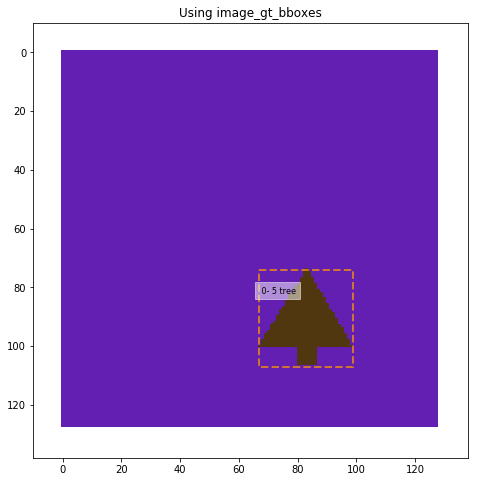

In [169]:
gt_box_count = np.count_nonzero(input_gt_class_ids[0])
print('Number of GT objects ', gt_box_count)
t1 = utils.boxes_to_image_domain(input_gt_bboxes[img_idx],input_image_meta[img_idx])
print(' input_gt_bboxes transformed to image domain:')
for i in range(gt_box_count):
    print(input_gt_bboxes[img_idx, i], '   --->', t1 [i])        
visualize.display_instances(input_image[0], t1[:10], input_gt_class_ids[0,:10], dataset_train.class_names, title='Using image_gt_bboxes')    
    

###  `output_rois`  :  Display output_rois without and with delta corrections

positiveroi count : 10


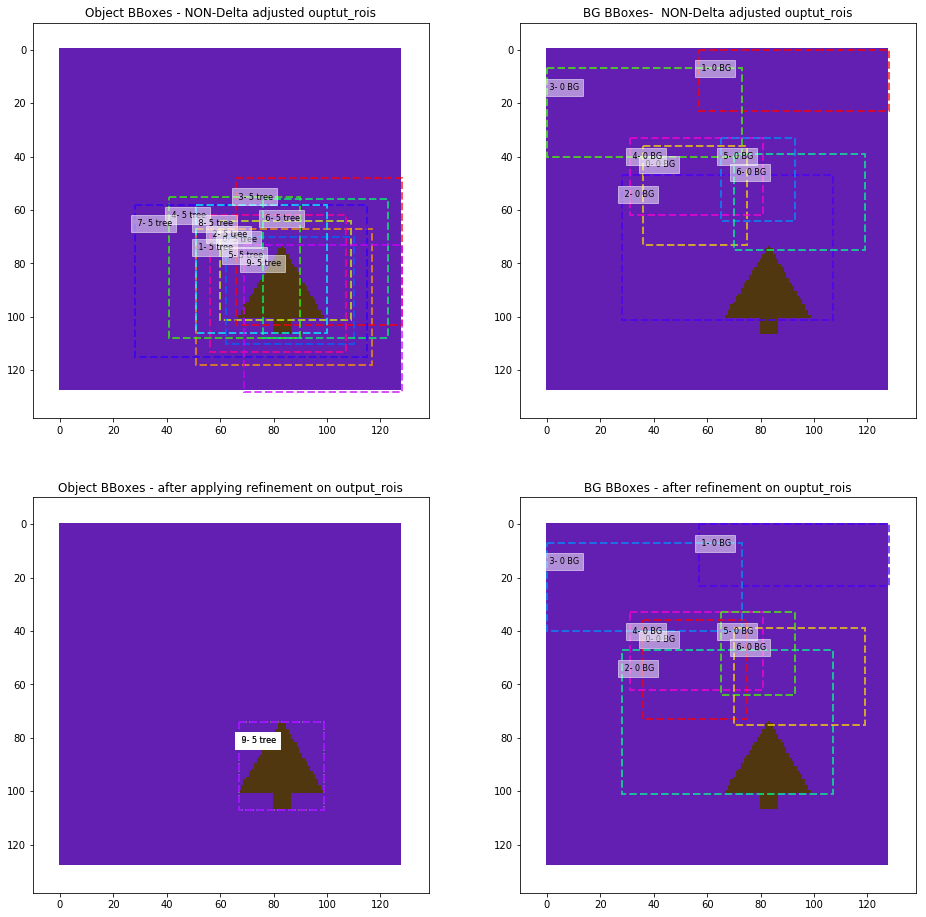

In [170]:
    scaler = [input_image.shape[1], input_image.shape[2],input_image.shape[1], input_image.shape[2]]    
    ##  t4:non delta-adjusted output rois 
    t4 = utils.boxes_to_image_domain(model_output_rois[img_idx] * scaler, input_image_meta[img_idx])
    #     print(t2 [:20])        
    pos_roi_count =  np.count_nonzero(model_target_class_ids[img_idx])
    print('positiveroi count :', pos_roi_count)
    bbox_deltas = model_target_bbox_deltas * mrcnn_model.config.BBOX_STD_DEV
#     print()
#     print('bbox deltas shape: ', bbox_deltas.shape)
#     print(bbox_deltas[0])

#     print()
#     print('output_rois in normalized context H:{} x W:{} '.format(input_image.shape[1], input_image.shape[2]))
#     print('shape :',model_output_rois.shape)
#     print(model_output_rois[0])

    t2 = utils.apply_box_deltas_np(model_output_rois[0], bbox_deltas[0]) 
#     print()
#     print(' output_rois adjusted by bbox_deltas :', t2.shape)
#     print(t2)

    t3 = utils.boxes_to_image_domain(t2 * scaler , input_image_meta[img_idx])
#     print()
#     print(' output_rois adjusted by bbox_deltas :', t3.shape)
#     print(t3)

    ax = visualize.get_ax(2, 2)
    visualize.display_instances(input_image[0], t4[:10], model_target_class_ids[0,:pos_roi_count], dataset_train.class_names, 
                                    title='Object BBoxes - NON-Delta adjusted ouptut_rois', ax = ax[0,0])  
    visualize.display_instances(input_image[0], t4[pos_roi_count:pos_roi_count+ 7], model_target_class_ids[0,pos_roi_count:pos_roi_count+ 7], dataset_train.class_names, 
                                    title='BG BBoxes-  NON-Delta adjusted ouptut_rois', ax = ax[0,1])  
    visualize.display_instances(input_image[0], t3[:pos_roi_count], model_target_class_ids[0,:pos_roi_count], dataset_train.class_names, 
                                    title='Object BBoxes - after applying refinement on output_rois', ax = ax[1,0])  
    visualize.display_instances(input_image[0], t3[pos_roi_count:pos_roi_count+ 7], model_target_class_ids[0,pos_roi_count:pos_roi_count+ 7], dataset_train.class_names, 
                                    title='BG BBoxes - after refinement on ouptut_rois', ax = ax[1,1])  
 

#### Display  `target_class_ids()`

In [220]:
print(' target_class_ids : ', target_class_ids.shape)
print(target_class_ids[0,:90])
print(' target_')
print(np.count_nonzero(target_class_ids[0]))

 target_class_ids :  (1, 200)
[ 1  1  1  1 38  1  1  1  1  1 38  1 38 38  1  1  1 38 38 38  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 38 38 38  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 target_
66


In [17]:
# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

# print(' mrcnn_bbox')
# print( mrcnn_bbox.shape)
# print( mrcnn_bbox)

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype)

# print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     print(pred_heatmap_scores[img,cls,:10])
#     print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

input_gt_class_ids
[38 38 38  1  1  1  1  1  1  1  1  1 38  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 output_rois
(1, 200, 4)
[[ 425.783   995.6045  446.5938 1020.1833]
 [ 425.1773 1002.7977  446.5236 1021.9712]
 [ 422.3943  828.2659  443.1353  850.8389]
 [ 420.8128  998.5729  447.1609 1014.7355]
 [ 679.6332  691.177   746.2022  895.992 ]
 [ 417.3315  317.9491  439.2289  334.9991]
 [ 419.7754  323.0784  441.5788  339.3224]
 [ 420.0803  824.3909  443.4798  841.3549]
 [ 415.5219  324.3896  432.7296  340.4197]
 [ 428.8941  908.5911  446.877   927.5968]
 [ 414.4317  318.8742  437.286   345.3727]
 [ 420.4667  823.4021  446.5974  848.1871]
 [ 398.6457  488.3748  710.7618  678.6857]
 [ 425.343   144.0605  596.3816  390.7286]
 [ 420.7793  999.2968  439.4089 1012.9329]
 [ 425.4

####  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [172]:
print(model_pred_heatmap_scores.shape)
print(model_pred_heatmap_scores[0,:,:10,:7])

(1, 7, 32, 23)
[[[   31.7837    32.3328    83.7053    60.0691     0.0000     0.9998    22.0000]
  [   14.0661    37.9727    33.5748    89.3079     0.0000     1.0000    21.0000]
  [   55.1705    32.5932   110.7832    56.9668     0.0000     0.5615    20.0000]
  [   16.1055     0.0000    63.4478    29.6302     0.0000     1.0000    19.0000]
  [   29.3106    25.5209    74.1513    52.6285     0.0000     0.9999    18.0000]
  [   29.8537    60.9762    72.4297    80.9472     0.0000     0.9996    17.0000]
  [   36.3761    62.7058    86.4840    95.2600     0.0000     1.0000    16.0000]
  [   42.4261    35.0076    91.0717    71.2068     0.0000     0.9998    15.0000]
  [   34.9385     1.4015   128.0000    49.5824     0.0000     0.9998    14.0000]
  [   17.8503     0.0000    78.0755    29.2141     0.0000     1.0000    13.0000]]

 [[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
  [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
  [    0.00

In [17]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print('input_gt_class_ids')
print(input_gt_class_ids[0])

# print(' rpn_bbox')
# print(rpn_bbox.shape)
# print(rpn_bbox[0,:100,:])

# print(' rpn_roi_proposals')
# print(rpn_roi_proposals.shape)
# print(rpn_roi_proposals[0,:100,:])

print(' output_rois')
print(output_rois.shape)
# print(output_rois[0,:40,:])
print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

# print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])
 

# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:,:])

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype)

# print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     print(pred_heatmap_scores[img,cls,:10])
#     print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

input_gt_class_ids
[38 38 38  1  1  1  1  1  1  1  1  1 38  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 output_rois
(1, 200, 4)
[[ 425.783   995.6045  446.5938 1020.1833]
 [ 425.1773 1002.7977  446.5236 1021.9712]
 [ 422.3943  828.2659  443.1353  850.8389]
 [ 420.8128  998.5729  447.1609 1014.7355]
 [ 679.6332  691.177   746.2022  895.992 ]
 [ 417.3315  317.9491  439.2289  334.9991]
 [ 419.7754  323.0784  441.5788  339.3224]
 [ 420.0803  824.3909  443.4798  841.3549]
 [ 415.5219  324.3896  432.7296  340.4197]
 [ 428.8941  908.5911  446.877   927.5968]
 [ 414.4317  318.8742  437.286   345.3727]
 [ 420.4667  823.4021  446.5974  848.1871]
 [ 398.6457  488.3748  710.7618  678.6857]
 [ 425.343   144.0605  596.3816  390.7286]
 [ 420.7793  999.2968  439.4089 1012.9329]
 [ 425.4

In [12]:
# print(rpn_roi_proposals[0])
# print(np.argmax(mrcnn_class[0],axis=1))
print(mrcnn_class[0,:20])
print(np.max(mrcnn_class[0,:],axis = 1))
argmax = np.argmax(mrcnn_class[0,:],axis = 1)
print(' arg_max. mrcnn_class')
print(argmax)
print()
for i in argmax:
    print(class_names[i])
# print(output_rois[0])
# print(pred_tensor[0])

[[0.018  0.9814 0.     ... 0.     0.     0.    ]
 [0.2677 0.7293 0.0001 ... 0.     0.     0.    ]
 [0.2258 0.7611 0.0001 ... 0.     0.     0.    ]
 ...
 [0.0055 0.     0.     ... 0.     0.     0.    ]
 [0.0003 0.9997 0.     ... 0.     0.     0.    ]
 [0.1434 0.842  0.     ... 0.     0.     0.    ]]
[0.9814 0.7293 0.7611 0.854  0.9724 0.9998 0.562  0.6519 0.5253 0.8295 0.9127 0.9944 0.9738 0.5337
 0.7673 0.6811 0.7946 0.9915 0.9997 0.842  0.9705 0.7398 0.9387 0.9951 0.9423 0.9996 0.9467 0.6633
 0.9539 0.5793 0.8187 0.7158 0.9417 0.8296 0.8518 0.9123 0.982  0.9374 0.9999 0.4431 0.7964 0.7204
 0.6355 0.9139 0.8944 0.9807 0.993  0.9946 0.8718 0.6869 0.9004 0.9759 0.8104 0.9056 0.3935 0.915
 0.9998 0.3691 0.9499 0.9161 0.6746 0.8826 0.949  0.8131 0.9584 0.7803 0.9996 0.9988 1.     0.9993
 0.9976 0.9982 0.9655 1.     0.9862 0.998  0.9995 0.9986 0.9678 0.9998 0.9965 0.9685 0.9994 1.
 0.9968 0.9965 0.5131 0.995  0.9995 0.9998 1.     0.999  1.     0.9992 0.9972 0.9986 0.9451 0.9779
 0.9989 0.99

In [23]:
# print(input_gt_boxes.shape, input_image.shape)

# print((rpn_proposal_rois[0,:5,:]*[128,128,128,128]))
# print(input_gt_class_ids)
print(input_normlzd_gt_bboxes)
print(input_gt_bboxes_norm.shape)
print(rpn_roi_proposals.shape)

Tensor("Identity:0", shape=(1, 100, 4), dtype=float64)
(1, 100, 4)
(1, 2000, 4)


## `detections_target_graph()`

###  Setup tensors to be passed to `detections_target_graph()`

This is passed to the DetectionTargetLayer

     output_rois, target_class_ids, target_bbox_deltas,  roi_gt_boxes = \
                DetectionTargetLayer_mod(config, name="proposal_targets") ([rpn_proposal_rois, input_gt_class_ids, input_normlzd_gt_boxes])                

In [106]:
import mrcnn.utils  as utils
# from mrcnn.detect_tgt_layer_mod import overlaps_graph_mod

image_id = 0
proposals    = KB.identity(model_rpn_roi_proposals)[image_id]
gt_class_ids = KB.identity(input_gt_class_ids)[image_id]
gt_boxes     = KB.cast(KB.identity(input_gt_bboxes_norm), dtype='float32')[image_id]
config       = mrcnn_model.config
# gt_masks     = KB.identity(input_gt_masks)
print(proposals.dtype, gt_class_ids.dtype, gt_boxes.dtype)
print(proposals.shape)
#     print(proposals.eval())
print(gt_class_ids.shape)
# print(gt_class_ids.eval())
print(gt_boxes.shape)
# print(gt_boxes.eval())
# proposals    = rpn_roi_proposals[1]
# gt_class_ids = input_gt_class_ids[1]
# gt_boxes     = input_normlzd_gt_boxes[1]
# gt_masks     = input_gt_masks[1]
# config       = model.config

<dtype: 'float32'> <dtype: 'int32'> <dtype: 'float32'>
(2000, 4)
(100,)
(100, 4)


### def `dev_detection_targets_graph`

Copied from detection_target_layer_mod on 8/30/2018

In [16]:
# def detection_targets_graph_mod(proposals, gt_class_ids, gt_boxes,  config):


In [107]:
# from mrcnn.detect_tgt_layer import overlaps_graph
# def detection_targets_graph_mod(proposals, gt_class_ids, gt_boxes,  config):

ROI_GT_IOU_THRESHOLD = 0.2

# Assertions
asserts = [tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals], name="roi_assertion")]

with tf.control_dependencies(asserts):
    proposals = tf.identity(proposals)
# print('>>> detection_targets_graph ')
# print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
# print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
# print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
# print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

# Remove zero padding   
# non_zeros returns indicies to valid bboxes, which we use to index gt_class_ids, and gt_masks
proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
# gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

#------------------------------------------------------------------------------------------
# Handle COCO crowds
# A crowd box in COCO is a bounding box around several instances. Exclude
# them from training. A crowd box is given a negative class ID.
#------------------------------------------------------------------------------------------
# tf.where : returns the coordinates of true elements of  the specified conditon.
#            The coordinates are returned in a 2-D tensor where the first dimension (rows) 
#            represents the number of true elements, and the second dimension (columns) 
#            represents the coordinates of the true elements. 
#            Keep in mind, the shape of the output tensor can vary depending on how many 
#            true values there are in input. Indices are output in row-major order.
#
# tf.gather: Gather slices from params axis (default = 0) according to indices.
#            indices must be an integer tensor of any dimension (usually 0-D or 1-D). 
#            Produces an output tensor with shape:
#                   params.shape[:axis] + indices.shape + params.shape[axis + 1:] 
#
# tf.squeeze: Removes dimensions of size 1 from the shape of a tensor.
#            Given a tensor input, this operation returns a tensor of the same type with 
#            all dimensions of size 1 removed. If you don't want to remove all size 1 
#            dimensions, you can remove specific size 1 dimensions by specifying axis.
#------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------
##  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications
#------------------------------------------------------------------------------------------
crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]    
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)    
# crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)

gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes    , non_crowd_ix)
# gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)

#------------------------------------------------------------------------------------------
# Compute overlaps with crowd boxes [anchors, crowds]
#------------------------------------------------------------------------------------------
print(proposals.shape, crowd_boxes.shape)
crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
print(type(crowd_overlaps))

crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)

#------------------------------------------------------------------------------------------
# Compute overlaps matrix [proposals, gt_boxes] - The IoU between 
# proposals and gt_boxes (non-crowd gt boxes, designated by classId < 0 in Coco)
# overlaps is 
# compute max of elements across axis 1 of overlaps tensor. 
#------------------------------------------------------------------------------------------
overlaps        = overlaps_graph(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)
print('     overlaps.shape        :',  overlaps.shape, KB.int_shape(overlaps)   )

#------------------------------------------------------------------------------------------
## 1. Determine indices of postive ROI propsal boxes
#------------------------------------------------------------------------------------------
#    Identify ROI proposal boxes that have an IoU >= 05 overlap with some gt_box, and store 
#    indices into positive_indices
positive_roi_bool     = (roi_iou_max >= ROI_GT_IOU_THRESHOLD)
positive_indices      = tf.where(positive_roi_bool)[:, 0]

#------------------------------------------------------------------------------------------
## 2. Determine indices of negative ROI proposal boxes
#------------------------------------------------------------------------------------------
#    those with < 0.5 with every GT box and are not crowds bboxes 
# the where creates a array with shape [# of answers, 1] so we use [:, 0] after
## current method
negative_indices      = tf.where(tf.logical_and(roi_iou_max < ROI_GT_IOU_THRESHOLD, no_crowd_bool))[:, 0]

## new method
# this modification will determine negative ROI proposal boxes but in addition, 
# will suppress the zero RoIs from the indicies 
# note that   ( negative_bool         = ~positive_roi_bool)
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_indices2     = tf.where(negative_nonzero_bool) [:, 0]

#------------------------------------------------------------------------------------------
## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
#------------------------------------------------------------------------------------------
#    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
#    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE ~  11
positive_count        = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
positive_indices      = tf.random_shuffle(positive_indices)[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

#------------------------------------------------------------------------------------------
## 4. Add Negative ROIs. Add enough to maintain positive:negative ratio
#------------------------------------------------------------------------------------------
#     negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)
r = 1.0 / config.ROI_POSITIVE_RATIO
negative_count        = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
negative_indices      = tf.random_shuffle(negative_indices)[:negative_count]

#------------------------------------------------------------------------------------------
## 5.   Gather selected positive and negative ROIs
#------------------------------------------------------------------------------------------
positive_rois         = tf.gather(proposals, positive_indices)
negative_rois         = tf.gather(proposals, negative_indices)

#------------------------------------------------------------------------------------------
## 6.   Assign positive ROIs to GT boxes.
#------------------------------------------------------------------------------------------
#      roi_gt_box_assignment shows for each positive overlap, which class has the maximum overlap
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
print('     shape of positive overlaps is :', positive_overlaps.get_shape())

#------------------------------------------------------------------------------------------
## 7.   Compute bbox delta (between the selected positive RPN proposals and corrspoing gt bboxes)
#------------------------------------------------------------------------------------------
# calculate refinement (difference b/w positive rois and gt_boxes) for positive ROIs
roi_gt_deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
roi_gt_deltas /= config.BBOX_STD_DEV

#------------------------------------------------------------------------------------------
## 8.  prepare gt_masks 
#------------------------------------------------------------------------------------------
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
# transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
# roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
# boxes = positive_rois

# if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    # y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    # gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    # gt_h = gt_y2 - gt_y1
    # gt_w = gt_x2 - gt_x1
    # y1 = (y1 - gt_y1) / gt_h
    # x1 = (x1 - gt_x1) / gt_w
    # y2 = (y2 - gt_y1) / gt_h
    # x2 = (x2 - gt_x1) / gt_w
    # boxes = tf.concat([y1, x1, y2, x2], 1)

# box_ids = tf.range(0, tf.shape(roi_masks)[0])
# masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   # boxes,
                                   # box_ids,
                                   # config.MASK_SHAPE)

# Remove the extra dimension from masks.
# masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
# masks = tf.round(masks)

#------------------------------------------------------------------------------------------
## 9. Prepare final outputs
# Append negative ROIs and pad bbox roi_gt_deltas and masks that
# are not used for negative ROIs with zeros.
#------------------------------------------------------------------------------------------
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P), (0, 0)])


roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
roi_gt_deltas    = tf.pad(roi_gt_deltas   , [(0, N + P), (0, 0)])
roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])       
# masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

print(' roi_gt_boxes :  ' , tf.shape(roi_gt_boxes) )
print(' P:  ' , P,  ' N :    ', N)   
print('     roi.shape             :',  rois.shape            , tf.shape(rois))
print('     roi_gt_class_ids.shape:',  roi_gt_class_ids.shape, tf.shape(roi_gt_class_ids))
print('     roi_gt_deltas.shape   :',  roi_gt_deltas.shape   , tf.shape(roi_gt_deltas))
# print('     masks.shape           :',  masks.shape           , tf.shape(masks))
print('     roi_gt_boxes.shape    :',  roi_gt_boxes.shape    , tf.shape(roi_gt_boxes))
    
#     return rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes

(?, 4) (?, 4)
	>>> detection_targets_graph - calculate Overlaps_graph
	     overlaps_graph: shape of boxes1 before reshape:  (?, 4)
	     overlaps_graph: shape of boxes2 before reshape:  (?, 4)
	     overlaps_graph: shape of boxes1 after reshape:  (?, 4)
	     overlaps_graph: shape of boxes2 after reshape:  (?, 4)
	     overlaps_graph: shape of b2_y1 after split:  (?, 1)
	     overlaps_graph: iou shape:  (?, 1)
	     overlaps_graph:  shape of output overlaps: (?, ?)
<class 'tensorflow.python.framework.ops.Tensor'>
	>>> detection_targets_graph - calculate Overlaps_graph
	     overlaps_graph: shape of boxes1 before reshape:  (?, 4)
	     overlaps_graph: shape of boxes2 before reshape:  (?, 4)
	     overlaps_graph: shape of boxes1 after reshape:  (?, 4)
	     overlaps_graph: shape of boxes2 after reshape:  (?, 4)
	     overlaps_graph: shape of b2_y1 after split:  (?, 1)
	     overlaps_graph: iou shape:  (?, 1)
	     overlaps_graph:  shape of output overlaps: (?, ?)
     overlaps.shape    

In [55]:
sess = KB.get_session()
with sess.as_default():
    r_rois = rois.eval()
    r_roi_gt_class_ids = roi_gt_class_ids.eval()
    r_gt_class_ids     = gt_class_ids.eval()
    r_gt_boxes         = gt_boxes.eval()
    r_crowd_ix         = crowd_ix.eval()
    r_non_crowd_ix     = non_crowd_ix.eval()
    r_overlaps         = overlaps.eval()
    r_roi_iou_max      = roi_iou_max.eval()
    r_positive_indices   = positive_indices.eval()
    r_negative_indices     = negative_indices.eval()

In [108]:
###-----------------------------------------------------------------------------------------------------------------
sess = KB.get_session()
with sess.as_default():
    r_rois = rois.eval()
    r_roi_gt_class_ids = roi_gt_class_ids.eval()
    r_non_zeros        = non_zeros.eval()
    r_proposals        = proposals.eval()
    r_gt_class_ids     = gt_class_ids.eval()
    r_gt_boxes         = gt_boxes.eval()
    r_crowd_ix         = crowd_ix.eval()
    r_non_crowd_ix     = non_crowd_ix.eval()
    r_crowd_boxes   = crowd_boxes.eval()
    r_crowd_overlaps = crowd_overlaps.eval()
    r_positive_rois = positive_rois.eval()
    r_negative_rois = negative_rois.eval()
#     r_overlaps         = overlaps.eval()
    r_roi_iou_max      = roi_iou_max.eval()
#     r_positive_indices   = positive_indices.eval()
#     r_negative_indices     = negative_indices.eval()
###-----------------------------------------------------------------------------------------------------------------
# print(' non zeors    :', r_non_zeros.shape)
# print(r_non_zeros)
# print(' crowd ix     :', r_crowd_ix.shape)
# print(r_crowd_ix)
# print(' non_crowd_ix :', r_non_crowd_ix.shape)
# print(r_non_crowd_ix)
print(' gt_class_ids :', r_gt_class_ids.shape)
print(r_gt_class_ids)

# print(' gt_boxes    : ', r_gt_boxes.shape)
# print(r_gt_boxes)
print(' crowd boxes  :', r_crowd_boxes.shape)
print(r_crowd_boxes)

# print(' overlaps    : ', r_overlaps.shape)
# # print(r_overlaps)
print(' roi_iou_max  : ', r_roi_iou_max.shape, r_roi_iou_max.max())
print(r_roi_iou_max[:1000] )
print(r_roi_iou_max[1000:] )
print(' positive_rois  : ', r_positive_rois.shape)
print(r_positive_rois)
print(' negative_rois  : ', r_negative_rois.shape)
print(r_negative_rois)
# print(' positive_indices  : ', r_positive_indices.shape)
# print(r_positive_indices)
# print(' negative_indices  : ', r_negative_indices.shape)
# print(r_negative_indices)

print(' rois :', r_rois.shape)
print(r_rois[:20])
print(' roi_gt_class_ids :', r_roi_gt_class_ids.shape)
print(r_roi_gt_class_ids)

 gt_class_ids : (1,)
[5]
 crowd boxes  : (0, 4)
[]
 roi_iou_max  :  (119,) 0.78261584
[0.7826 0.6593 0.0407 0.5505 0.     0.2166 0.     0.     0.     0.0434 0.3762 0.     0.5134 0.
 0.     0.     0.     0.     0.     0.1375 0.0834 0.185  0.31   0.1254 0.     0.0131 0.     0.
 0.     0.     0.0775 0.1008 0.0083 0.     0.0337 0.     0.     0.123  0.2018 0.     0.     0.
 0.     0.     0.0001 0.     0.0835 0.1985 0.1029 0.     0.0956 0.     0.0089 0.     0.     0.
 0.0297 0.047  0.0277 0.     0.     0.     0.2022 0.     0.0501 0.     0.1769 0.     0.     0.
 0.     0.     0.     0.0411 0.     0.     0.     0.     0.     0.     0.     0.0875 0.0229 0.0025
 0.     0.     0.0233 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2251
 0.2194 0.     0.106  0.     0.2909 0.1683 0.     0.     0.     0.     0.1681 0.     0.     0.
 0.     0.     0.     0.     0.0116 0.     0.    ]
[]
 positive_rois  :  (10, 4)
[[0.6389 0.3945 0.9354 0.7488]
 [0.4115 0.1923 0.9694 0.8544]
 [0

### Display output

<class 'numpy.ndarray'>
Image meta  :  [7208  482  640    3  126    0  897 1024    1    1    1    1    1    1    1    1    1    1    1]
Classes     :  [1 1 1 1 1]
image_id    :  7208  Reference:  http://cocodataset.org/#explore?id=16056
image                    shape: (482, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (482, 640, 5)         min:    0.00000  max:    1.00000
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000
bbox                     shape: (5, 4)                min:   40.00000  max:  567.00000
5 5
Class Names :  ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']
12
i:  0 id : 0 class_id:  1
i:  1 id : 1 class_id:  1
i:  2 id : 2 class_id:  1
i:  3 id : 3 class_id:  1
i:  4 id : 4 class_id:  1
i:  5 id : 5 class_id:  1
i:  6 id : 6 class_id:  1
i:  7 id : 7 class_id:  1
i:  8 id : 8 class_id:  1
i:  9 id : 9 class_id:  0
 Skipping box  9
i:  1

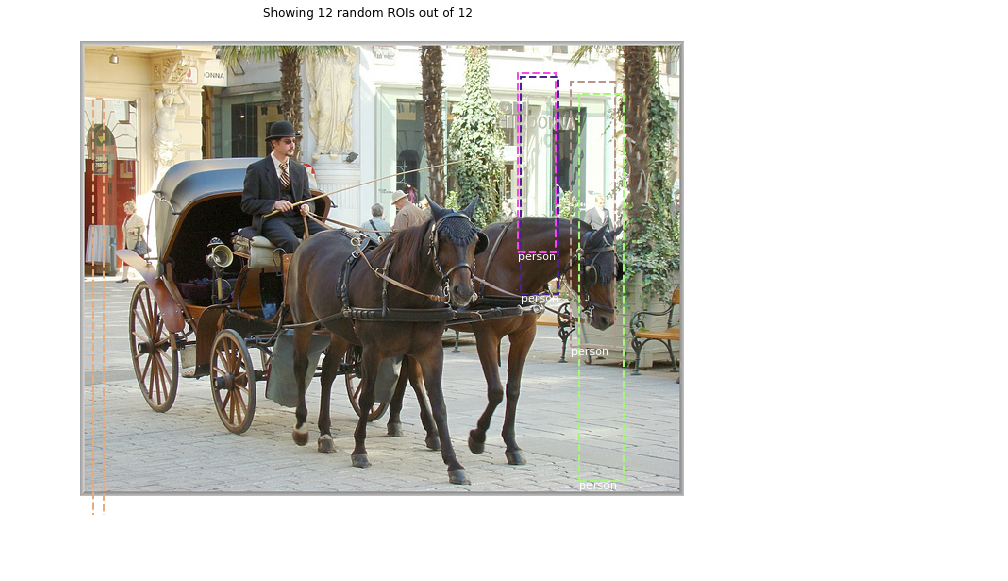

In [87]:
tf_mod_output_rois = utils.apply_box_deltas_tf(output_rois, target_bbox_deltas)
sess=tf.InteractiveSession()
with sess.as_default():
    mod_output_rois = tf_mod_output_rois.eval()
print(type(mod_output_rois))    
image_id = img_meta[img_idx,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
print('Image meta  : ', img_meta[img_idx])
print('Classes     : ', class_ids)
print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])    
# class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
class_names = dataset_train.class_names
print('Class Names : ', class_names)
# visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

unnorm_output_rois = mod_output_rois * [1024,1024,104,1024]
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)   
visualize.draw_output_rois(image, unnorm_output_rois[0,:12], target_class_ids[0,:12], class_names, limit=10)

In [ ]:
print(type(tt), len(tt))
print(' Shuffled Positive indices:\n', tt[0])
print(' Positive indices:         \n', tt[1])
print(' positive overlaps shape  :  ', tt[2].shape)
print(' positive overlaps        :\n', tt[2])
print(' Pos roi gt box assignment:\n', tt[5])    
print(' Pos roi gt class assign  :\n', tt[3])
print(' Pos roi gt boxes         :\n', tt[4])

sess1.close()

### overlaps_graph_mod

In [27]:
# with sess.as_default():
#     boxes1 = proposals
#     boxes2 = gt_boxes
def overlaps_graph(boxes1, boxes2):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 2000 (training) or 1000 (inference)
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
                        The dimensionality :
                            row:  number of non_zero proposals 
                            cols: number of non_zero gt_bboxes
    '''
    ##------------------------------------------------------------------------------------------------------------
    ## 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    ##    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    ##  b1: duplicate each row of boxes1 <boxes2.shape[0]> times 
    ##      R1,R2, R3 --> R1,R1,R1,..,R2,R2,R2,...,R3,R3,R3
    ##  b2: duplicate the set of rows in boxes2 <boxes1.shape[0]> times 
    ##      R1,R2,R3 --> R1,R2,R3,R1,R2,R3,....,R1,R2,R3
    ##------------------------------------------------------------------------------------------------------------
    
    print('\t>>> detection_targets_graph - calculate Overlaps_graph')    
    print('\t     overlaps_graph: shape of boxes1 before reshape: ',boxes1.shape)  # (?,?)
    print('\t     overlaps_graph: shape of boxes2 before reshape: ',boxes2.shape)  # (?,?)
    ### tf.expand_dims(boxes1, 1) ## makes b1:[1, batch_size, proposal_count_sz, 4] 
    
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    print('\t     overlaps_graph: shape of boxes1 after reshape: ', b1.shape)  # (?,4)
    print('\t     overlaps_graph: shape of boxes2 after reshape: ', b2.shape)  # (?,4)


    ##------------------------------------------------------------------------------------------------------------
    ## 2. Compute intersections
    ##------------------------------------------------------------------------------------------------------------
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    
    print('\t     overlaps_graph: shape of b2_y1 after split: ',b2_y1.shape)  # (?,4)
    
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    ##------------------------------------------------------------------------------------------------------------
    ## 3. Compute unions
    ##------------------------------------------------------------------------------------------------------------
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    
    ##------------------------------------------------------------------------------------------------------------
    ## 4. Compute IoU and reshape to [boxes1, boxes2]
    ##------------------------------------------------------------------------------------------------------------
    iou = intersection / union
    print('\t     overlaps_graph: iou shape: ', iou.shape)  # (?,4)
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
    print('\t     overlaps_graph:  shape of output overlaps:', overlaps.shape)
    return overlaps

In [163]:
with sess.as_default():
    r_proposals = proposals.eval()
    r_gt_boxes = gt_boxes.eval()
    r_b1 = b1.eval()
    r_b2 = b2.eval()
    r_b1_area = b1_area.eval()
    r_b2_area = b2_area.eval()
    r_intersection = intersection.eval()
    r_union = union.eval()
    r_iou   = iou.eval()
    r_overlaps = overlaps.eval()
    r_b1_y1 = b1_y1.eval()
    r_b1_y2 = b1_y2.eval()
    r_b1_x1 = b1_x1.eval()
    r_b1_x2 = b1_x2.eval()

In [164]:
r_int, r_un, r_io, r_ovr = overlaps_graph_np(r_proposals, r_gt_boxes)

print(' proposals', r_proposals.shape)
print(r_propsals[:10])
print(' gt_boexes', r_gt_boxes.shape)
print(' b1: ',r_b1.shape)
print(r_b1[:10])
print(' b2: ',r_b2.shape)
print(r_b2[:18])
print()
# print(r_b2[1067:1079])
print(' b1_area:', r_b1_area.shape)
# print(r_b1_area)
print(' b2_area:', r_b2_area.shape)
# print(r_intersection[:1000])
print(' intersection :', r_intersection.shape, r_int.shape, 'equal :', np.all(r_intersection == r_int))
print('        union :', r_union.shape, r_un.shape, 'equal :', np.all(r_union == r_un))
print('          iou :', r_iou.shape, r_io.shape, 'equal :', np.all(r_iou == r_io))
print('      overlaps:', r_overlaps.shape, r_ovr.shape, 'equal :', np.all(r_overlaps == r_ovr))
# print(r_b1_y1.shape,r_b1_x1.shape,r_b1_y2.shape)

(2000, 4)
(6, 4)
 proposals (2000, 4)
[[    0.3529     0.0050     0.7980     0.4266]
 [    0.4176     0.0665     0.7590     0.3764]
 [    0.2087     0.3628     0.4743     0.7046]
 [    0.3898     0.4291     0.8150     0.9826]
 [    0.1800     0.0492     0.4067     0.3939]
 [    0.3551     0.4749     0.6296     0.7941]
 [    0.1352     0.2704     0.5262     0.7751]
 [    0.3326     0.8494     0.5428     0.9836]
 [    0.1480     0.0000     0.4423     0.4698]
 [    0.1582     0.8671     0.3554     0.9929]]
 gt_boexes (6, 4)
 b1:  (12000, 4)
[[    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4180     0.3271     0.5681     0.9164]
 [    0.4262     0.4544     0.5569     0.9339]
 [    0.4262     0.4544     0.5569     0.9339]
 [    0.4262     0.4544     0.5569     0.9339]
 [    0.4262     0.4544     0.556

In [53]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)

In [139]:
def overlaps_graph_np(proposals, gt_boxes):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 2000 (training) or 1000 (inference)
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
                        The dimensionality :
                            row:  number of non_zero proposals 
                            cols: number of non_zero gt_bboxes
    '''
    tst1 = r_proposals
    tst2 = r_gt_boxes
    print(tst1.shape)
    print(tst2.shape)
    ##------------------------------------------------------------------------------------------------------------
    ## 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    ##    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    ##  b1: duplicate each row of boxes1 <boxes2.shape[0]> times 
    ##      R1,R2, R3 --> R1,R1,R1,..,R2,R2,R2,...,R3,R3,R3
    ##  b2: duplicate the set of rows in boxes2 <boxes1.shape[0]> times 
    ##      R1,R2,R3 --> R1,R2,R3,R1,R2,R3,....,R1,R2,R3
    ##------------------------------------------------------------------------------------------------------------
    b1 = np.repeat(proposals, gt_boxes.shape[0],axis =0)
    b2 = np.tile(gt_boxes, (proposals.shape[0],1))    # repeat number of times of r_gt_boxes
    
    ##------------------------------------------------------------------------------------------------------------
    ## 2. Compute intersections
    ## b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    ## b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    ##------------------------------------------------------------------------------------------------------------
    y1 = np.maximum(b1[:,0], b2[:,0])
    x1 = np.maximum(b1[:,1], b2[:,1])
    y2 = np.minimum(b1[:,2], b2[:,2])
    x2 = np.minimum(b1[:,3], b2[:,3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    ##------------------------------------------------------------------------------------------------------------
    ## 3. Compute unions
    ##------------------------------------------------------------------------------------------------------------
    b1_area = (b1[:,2] - b1[:,0]) * (b1[:,3] - b1[:,1])
    b2_area = (b2[:,2] - b2[:,0]) * (b2[:,3] - b2[:,1])
    union = b1_area + b2_area - intersection
    iou = intersection / union

    overlaps = np.reshape(iou, (proposals.shape[0], gt_boxes.shape[0]))
    return np.expand_dims(intersection, axis =1), np.expand_dims(union,axis = 1), np.expand_dims(iou, axis = 1), overlaps


# print( 'rintersectoin:', rintersection.shape)
# print(r_intersection.shape)
# print('intersectoin check: ', np.all(rintersection == np.squeeze(r_intersection)))
# print('riou: ', riou.shape, 'r_iou:' ,r_iou.shape)
# print('iou check         : ',np.all(riou == np.squeeze(r_iou)))
# print('roverlaps: ', roverlaps.shape, 'r_overlaps:' ,r_overlaps.shape)
# print('overlaps check         : ',np.all(roverlaps == np.squeeze(r_overlaps)))
# print(rintersection[:20])
# print(r_intersection[:20])
# print(np.all(bb1_y1 == np.squeeze(r_b1_y1)))
# print(bb1_y1.shape, bb1_x1.shape)
# print(bb1_y1[:10], np.squeeze(r_b1_y1[:10])) ##bb1_x1[:10], bb1_y2[:10], bb1_x2[:10])
# print(roverlaps[:10])
# print(r_overlaps[:10])

###  `detect_target_layer` -- non function format

### Display Model Output


####  Display roi_gt_boxes along with corresponding refined/clipped output_rois

In [110]:
####  Display roi_gt_boxes along with corresponding refined/clipped output_rois

img_id = 0
print(model_roi_gt_boxes[0].shape, model_target_class_ids[0].shape , np.expand_dims(model_target_class_ids[0],axis=-1).shape)
print(model_mrcnn_class.shape, model_mrcnn_bbox.shape)
 
print(np.argmax(model_mrcnn_class, axis = -1))
classes, deltas = utils.get_predicted_mrcnn_deltas(model_mrcnn_class, model_mrcnn_bbox, verbose=True)
deltas *= mrcnn_model.config.BBOX_STD_DEV
print('classes.shape: ',classes.shape, ' deltas.shape: ',deltas.shape)

ref_out_roi = utils.apply_box_deltas_np(model_output_rois[img_id],deltas[img_id])
#     ##   Clip boxes to image window    
print('ref_out_roi')
print(ref_out_roi.shape)
print(ref_out_roi)
window = np.array([0,0,h,w], dtype =float)
print(window)
clipped_out_roi  = utils.clip_to_window_np( window, ref_out_roi*[ h, w, h, w])

for i in range(32):
#     ref_out_roi = utils.apply_box_delta_np(output_rois[0],d1[0])
#     if classes[img_id,i] == 1 or target_class_ids[img_id,i] == 1 :

    print('id: ', 32-i,
               ' GT : ', model_target_class_ids[img_id,i]  , 
               ' -', model_roi_gt_boxes[img_id,i]*[ h, w, h, w], 
               '\n\t\t\t    Raw Roi (Norm): ', model_output_rois[img_id,i],
               '\n\t\t\t             Delta: ', deltas[img_id,i],
               '\n\t\t\t    Raw Roi  (Img): ', model_output_rois[img_id,i]*[ h, w, h, w],
               '\n   PR Cls: ', classes[img_id,i],'\t',
               '        Roi w/Delta Apply: ', ref_out_roi[i]*[ h, w, h, w] ,
               '\n\t\t\t      Clipped Rois: ', clipped_out_roi[i]   ) #) *[1024,1024,1024,1024]

(32, 4) (32,) (32, 1)
(1, 32, 7) (1, 32, 7, 4)
[[5 5 5 5 0 5 5 0 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
mrcnn_class shape: (1, 32, 7)
mrcnn_bbox shape : (1, 32, 7, 4)
predicted_classes: (1, 32)
predicted_deltas : (1, 32, 4)
classes.shape:  (1, 32)  deltas.shape:  (1, 32, 4)
ref_out_roi
(32, 4)
[[ 0.6743  0.3705  0.962   0.6594]
 [ 0.671   0.3817  0.9734  0.661 ]
 [ 0.6767  0.3794  0.9658  0.6837]
 [ 0.6594  0.3765  0.986   0.679 ]
 [ 0.3421 -0.0765  1.3061  0.3362]
 [ 0.6727  0.3889  0.9636  0.6658]
 [ 0.6803  0.3805  0.973   0.6572]
 [ 0.3543  0.1532  1.3148  0.5154]
 [ 0.6817  0.383   0.9808  0.6521]
 [ 0.6672  0.3598  0.9425  0.6769]
 [ 0.0993  0.3813  0.2188  0.693 ]
 [ 0.2457  0.3505  0.5334  0.4423]
 [ 0.2435  0.214   0.6456  0.3996]
 [ 0.2728  0.1675  0.6818  0.3895]
 [ 0.1778 -0.0603  0.6936  0.1306]
 [ 0.2017 -0.2379  0.8028  0.1178]
 [ 0.2529  0.1169  0.8082  0.4409]
 [ 0.1864 -0.0995  0.4531  0.46  ]
 [ 0.3251  0.403   0.7442  0.6545]
 [ 0.173  -0.2115  0.811   0.

#### display gt_heatmap_scores and pred_heatmap_scores outputs

In [111]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores  : ', model_gt_heatmap_scores.dtype  ,  model_gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', model_pred_heatmap_scores.dtype,  model_pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(25):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img_id:',img_id, ' cls: ',cls, ' -',model_gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img_id:',img_id, ' cls: ',cls, ' -',model_pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

 GT Heatmap Scores
gt_heatmap_scores  :  float32 (1, 7, 32, 23)
pred_heatmap_scores:  float32 (1, 7, 32, 23)
--------------------------------------------------------
Image : 0  GT ClassIds: [0, 5]   PR ClassIds: [0, 5] 
Image : 0  Union ClassIds: [0 5]
--------------------------------------------------------

 GT: img_id: 0  cls:  0  - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 PR: img_id: 0  cls:  0  - [  43.7894    0.      128.       43.0386    0.        0.492    28.        0.492     1.     3624.307     0.492    45.0247  130.        0.3463    0.5182    1.        0.4861       nan  130.
       nan       nan    1.           nan]

 GT: img_id: 0  cls:  0  - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 PR: img_id: 0  cls:  0  - [  45.3546   19.6072  128.       65.9676    0.        0.6782   25.        0.6782    1.     3831.4775    0.6782   62.074   130.        0.4775    0.7145    1.        0.6702       nan  130.
       nan       nan  